In [1]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ordered_set import OrderedSet
import numpy as np

c:\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Load the model used to calculate sentence representations

model = SentenceTransformer("all-roberta-large-v1")

c:\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Load the datasets of all separate domains 

ds_wiki = load_dataset("DanteZD/HC3_plus_llama70B", split="wiki_csai")
ds_openqa = load_dataset("DanteZD/HC3_plus_llama70B", split="open_qa")
ds_finance = load_dataset("DanteZD/HC3_plus_llama70B", split="finance")
ds_medicine = load_dataset("DanteZD/HC3_plus_llama70B", split="medicine")
ds_reddit = concatenate_datasets([
    load_dataset("DanteZD/HC3_plus_llama70B", split="reddit_test"),
    load_dataset("DanteZD/HC3_plus_llama70B", split="reddit_train"),    
]).select(range(0, 842))

In [4]:
# Function for creating a dict with that contains the lists of human/ai-generated answers
def answer_dict(dataset, answer_types = ['human_answers', "chatgpt_answers", "llama_answers", "llama_8B_answers"]):
    # Create returned dictionary skeleton
    results = {}
    for generator in answer_types:
        results[generator] = []

    # Fill in dictionary 
    for generator in answer_types:
        for entry in dataset:
            results[generator].append(entry[generator][0])
    
    return results

In [5]:
# Create the dictionaries

dict_wiki = answer_dict(ds_wiki)
dict_openqa = answer_dict(ds_openqa)
dict_finance= answer_dict(ds_finance)
dict_medicine = answer_dict(ds_medicine)
dict_reddit = answer_dict(ds_reddit)

In [6]:
# Function for creating a dict with the embeddings for specific answer types
def embeddings_dict(domain_dict, answer_types = ['human_answers', "chatgpt_answers", "llama_answers", "llama_8B_answers"]):  
    result = {}

    for generator in answer_types:
        # Create the embeddings for all generated answers by a generator
        embeddings = model.encode(domain_dict[generator])
        # Store all embeddings as np array for each generator
        result[generator] = embeddings

    return result

In [7]:
# Create the embedding dictionaries -> This will take a minute

reddit_embs = embeddings_dict(dict_reddit)
wiki_embs = embeddings_dict(dict_wiki)
openqa_embs = embeddings_dict(dict_openqa)
finance_embs = embeddings_dict(dict_finance)
medicine_embs = embeddings_dict(dict_medicine)

In [8]:
# Create a dictionary for each generator with the domains as keys and all there sentence embeddings as values
embeddings_list = [reddit_embs, wiki_embs, openqa_embs, finance_embs, medicine_embs]
embeddings_names = ["reddit_eli5", "wiki", "open_qa", "finance", "medicine"]
generators = ['human_answers', "chatgpt_answers", "llama_answers", "llama_8B_answers"]

def create_generator_dict(generator, embs_list, embs_names):
    result = {}
    for domain_name, domain_embs in zip(embs_names, embs_list):
        result[domain_name] = domain_embs[generator]
    return result

human_embs = create_generator_dict("human_answers", embeddings_list, embeddings_names)
chatgpt_embs = create_generator_dict("chatgpt_answers", embeddings_list, embeddings_names)
llama70B_embs = create_generator_dict("llama_answers", embeddings_list, embeddings_names)
llama8B_embs = create_generator_dict("llama_8B_answers", embeddings_list, embeddings_names)

In [9]:
# Get the similarity scores between all embeddings of answers generated across generators and domains
generator_embs_list = [human_embs, chatgpt_embs, llama70B_embs, llama8B_embs]

# Create skeleton dictionary
mean_sim_dict = {}
for generator_name_i in generators:
    mean_sim_dict[generator_name_i] = {}
    for generator_name_j in generators:
        mean_sim_dict[generator_name_i][generator_name_j] = {}
        for domain_name_i in embeddings_names:
            mean_sim_dict[generator_name_i][generator_name_j][domain_name_i] = {}

# Calculate similarity score across generators and domains
for generator_name_i, generator_i in zip(generators, generator_embs_list):
    for generator_name_j, generator_j in zip(generators, generator_embs_list):
        for domain_name_i in embeddings_names:
            for domain_name_j in embeddings_names:
                # Calculate the sim between answers of generator_i and domain_i and generator_j and domain_j:
                # E.g., i = human + wiki vs j = llama70B + reddit_eli5 -> (Making all possible combo's)
                sim_scores = model.similarity(generator_i[domain_name_i], generator_j[domain_name_j])
                # Filter out only the upper triangle of the similarity matrix 
				# (excluding the diagonal) IF the domains and generators are equal:
                if domain_name_i == domain_name_j and generator_name_i == generator_name_j:
                    upper_tri = torch.triu(sim_scores, diagonal=1)
                    upper_tri_sim_scores = upper_tri[upper_tri != 0]
                # Else include the diagonal
                else:
                    upper_tri = torch.triu(sim_scores, diagonal=0)
                    upper_tri_sim_scores = upper_tri[upper_tri != 0]
                # Take the average sim_score over all the similarities calculated between answers
                mean_sim_score = upper_tri_sim_scores.mean().item()
                mean_sim_dict[generator_name_i][generator_name_j][domain_name_i][domain_name_j] = mean_sim_score              

In [10]:
def fix_gen_name(generator_name):
    if generator_name == "llama_answers":
        return "llama_70B"
    else:
        return generator_name.split("_answers")[0]

# Flatten the nested dict into a row by row structure for plotting
sim_array = np.zeros([20, 20])
row_names = OrderedSet()
column_names = OrderedSet()
for i, (generator_i, generator_data) in enumerate(mean_sim_dict.items()):
    for j, (generator_j, domain_i_data) in enumerate(generator_data.items()):
        for k, (domain_i, domain_j_data) in enumerate(domain_i_data.items()):
            x = 5 * i + k
            for l, (domain_j, sim_score) in enumerate(domain_j_data.items()):
                y = 5 * j + l
                gen_i = fix_gen_name(generator_i)
                gen_j = fix_gen_name(generator_j)
                row_names.add((gen_i, domain_i))
                column_names.add((gen_j, domain_j))
                sim_array[x, y] = sim_score

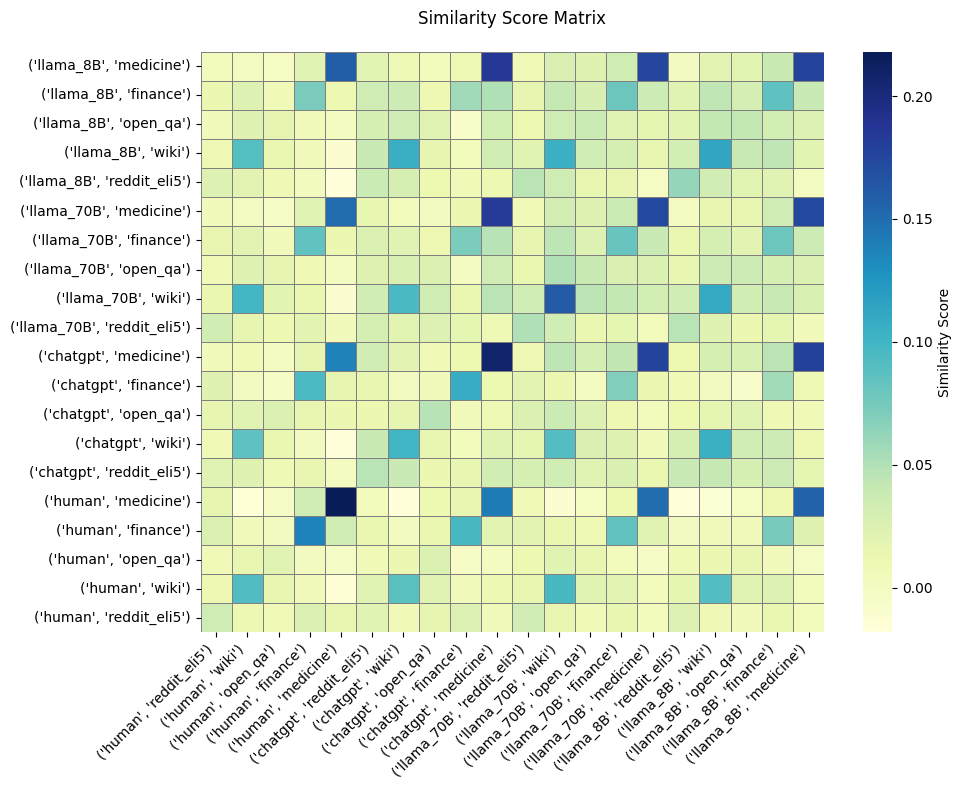

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_array, annot=False, cmap="YlGnBu", linewidths=0.5, fmt=".4f",
            xticklabels=row_names, yticklabels=column_names, linecolor='gray', cbar_kws={'label': 'Similarity Score'},
            )
plt.gca().invert_yaxis()
plt.title("Similarity Score Matrix", pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# CODE FOR DOMAIN + GENERATOR
domain_mean_sim_dict = {}
for domain_name_i, domain_embs_i in zip(embeddings_names, embeddings_list):
    domain_mean_sim_dict[domain_name_i] = {}
    for domain_name_j, domain_embs_j in zip(embeddings_names, embeddings_list):
        domain_mean_sim_dict[domain_name_i][domain_name_j] = {}
        for generator_i in generators:
            domain_mean_sim_dict[domain_name_i][domain_name_j][generator_i] = {}

# Calculate similarity scores across domain and generators
output_array = np.zeros([20,20])
for domain_name_i, domain_embs_i in zip(embeddings_names, embeddings_list):               
    for domain_name_j, domain_embs_j in zip(embeddings_names, embeddings_list):
        for generator_name_i, generator_i in zip(generators, generator_embs_list):
            for generator_name_j, generator_j in zip(generators, generator_embs_list):
                # Calculate similarity between answers of domain_i for generator_i and domain_j for generator j thus:
                # domain_i (wiki/med/fin/etc) indexed by generator i (human/chatgpt/llama70B/llama8B)
                # domain_j (wiki/med/fin/etc) indexed by generator j (human/chatgpt/llama70B/llama8B)
                # E.g., i = wiki and llama70B vs j = med and chatgpt
                # Thus make all combinations possible and calculate the similarity between all individual answers
                sim_scores = model.similarity(domain_embs_i[generator_name_i], domain_embs_j[generator_name_j])
                # Filter out only the upper triangle of the similarity matrix
                # (excluding the diagonal) IF the domains and generators are equal:
                if domain_name_i == domain_name_j and generator_name_i == generator_name_j:
                    upper_tri = torch.triu(sim_scores, diagonal=1)
                    upper_tri_sim_scores = upper_tri[upper_tri != 0]
                # Else include the diagonal
                else:
                    upper_tri = torch.triu(sim_scores, diagonal=0)
                    upper_tri_sim_scores = upper_tri[upper_tri != 0]
                # Take the average sim_score over all the similarities calculated between answers
                mean_sim_score = upper_tri_sim_scores.mean().item()
                domain_mean_sim_dict[domain_name_i][domain_name_j][generator_name_i][generator_name_j] = mean_sim_score     

In [13]:
# Flatten the nested dict into a row by row structure for plotting
sim_array = np.zeros([20, 20])
row_names = OrderedSet()
column_names = OrderedSet()
for i, (domain_i, domain_data) in enumerate(domain_mean_sim_dict.items()):
    for j, (domain_j, generator_i_data) in enumerate(domain_data.items()):
        for k, (generator_i, generator_j_data) in enumerate(generator_i_data.items()):
            x = 4 * i + k
            for l, (generator_j, sim_score) in enumerate(generator_j_data.items()):
                y = 4 * j + l
                gen_i = fix_gen_name(generator_i)
                gen_j = fix_gen_name(generator_j)  
                row_names.add((domain_i, gen_i))
                column_names.add((domain_j, gen_j))
                sim_array[x, y] = sim_score

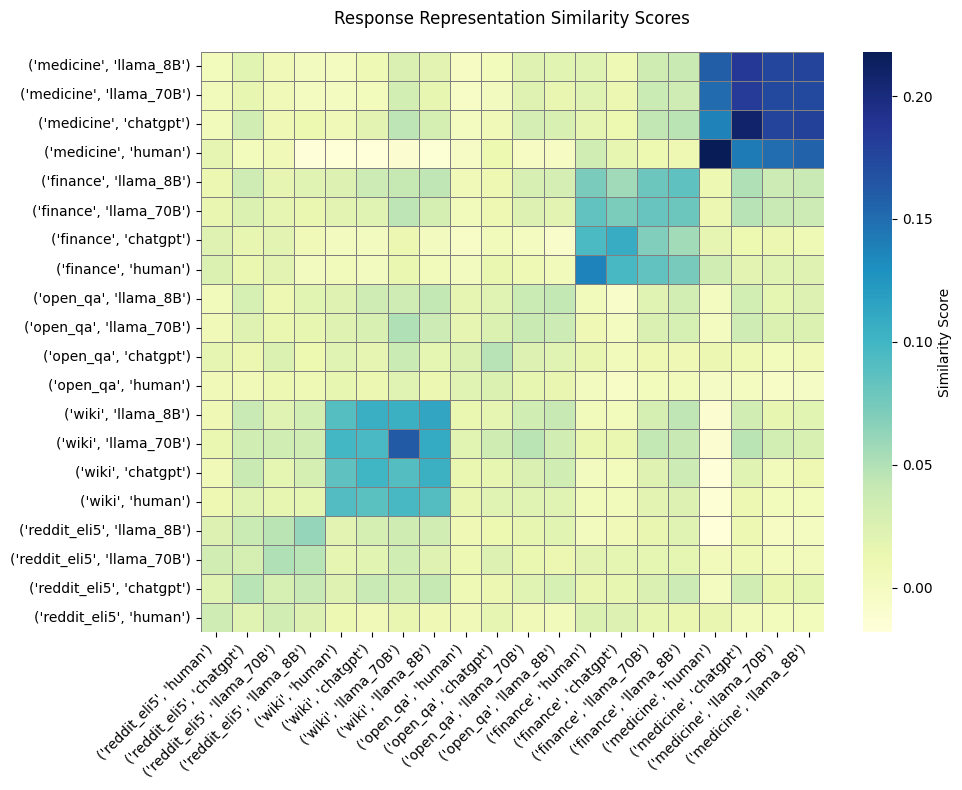

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_array, annot=False, cmap="YlGnBu", linewidths=0.5, fmt=".4f",
            xticklabels=row_names, yticklabels=column_names, linecolor='gray', cbar_kws={'label': 'Similarity Score'},
            )
plt.gca().invert_yaxis()
plt.title("Response Representation Similarity Scores", pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()